In [63]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import pyedflib

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import ipywidgets as widgets
from matplotlib import gridspec
import matplotlib.image as mpimg
from scipy.signal import hilbert, filtfilt, find_peaks, lfilter

project_root = '..'
sys.path.append(project_root)

from sleeprnn.data.inta_ss import IntaSS, NAMES, IDS_TEST
from sleeprnn.data import utils, stamp_correction
from sleeprnn.detection import metrics
from sleeprnn.data.loader import RefactorUnpickler
from sleeprnn.common import constants, pkeys

SEED_LIST = [123, 234, 345, 456]
RESULTS_PATH = os.path.join(project_root, 'results')
COMPARISON_PATH = os.path.join(project_root, 'resources', 'comparison_data')
DPI = 200
CUSTOM_COLOR = {'red': '#c62828', 'grey': '#455a64', 'blue': '#0277bd', 'green': '#43a047'} 

%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [136]:
# look for intersections between stamps of the same validity
def overlap_matrix(events, detections):
    # Matrix of overlap, rows are events, columns are detections
    n_det = detections.shape[0]
    n_gs = events.shape[0]
    overlaps = np.zeros((n_gs, n_det))
    for i in range(n_gs):
        candidates = np.where(
            (detections[:, 0] <= events[i, 1])
            & (detections[:, 1] >= events[i, 0]))[0]
        for j in candidates:
            intersection = min(
                events[i, 1], detections[j, 1]
            ) - max(
                events[i, 0], detections[j, 0]
            ) + 1
            if intersection > 0:
                overlaps[i, j] = 1
    return overlaps


def overlapping_groups(overlap_matrix):
    groups_overlap = [[0]]
    for i in range(overlap_matrix.shape[0]):
        visited = np.any([i in single_group for single_group in groups_overlap])
        if not visited:
            # Check if intersects with an existent group
            added = False
            for single_group in groups_overlap:
                is_overlapping = np.any(overlap_matrix[i, single_group])
                if is_overlapping:
                    single_group.append(i)
                    added = True
                    break
            if not added:
                # Then variable is a new group
                groups_overlap.append([i])
    return groups_overlap


def read_and_format(path_stamps, path_signals, min_samples=20):
    with pyedflib.EdfReader(path_signals) as file:
        signal = file.readSignal(0)
        channel_name = file.getLabel(0)
        print('Reading', channel_name)
        signal_len = signal.shape[0]
    data = np.loadtxt(path_stamps)
    for_this_channel = (data[:, -1] == 1)
    data = data[for_this_channel]
    data = np.round(data).astype(np.int32)

    # Remove zero duration marks, and ensure that start time < end time
    new_data = []
    for i in range(data.shape[0]):
        if data[i, 0] > data[i, 1]:
            print('End time < Start time fixed')
            aux = data[i, 0]
            data[i, 0] = data[i, 1]
            data[i, 1] = aux
            new_data.append(data[i, :])
        elif data[i, 0] < data[i, 1]:
            new_data.append(data[i, :])
        else:  # Zero duration (equality)
            print('Zero duration stamp found and removed')
    data = np.stack(new_data, axis=0)
    
    # Remove marks with duration less than min_samples
    new_data = []
    for i in range(data.shape[0]):
        if data[i, 1] - data[i, 0] >= min_samples:
            new_data.append(data[i, :])
        else:
            print('Stamp with too few samples removed')
    data = np.stack(new_data, axis=0)

    # Remove stamps outside signal boundaries
    new_data = []
    for i in range(data.shape[0]):
        if data[i, 1] < signal_len:
            new_data.append(data[i, :])
        else:
            print('Stamp outside boundaries found and removed')
    data = np.stack(new_data, axis=0)

    raw_stamps = data[:, [0, 1]]
    valid = data[:, 4]
    raw_stamps_1 = raw_stamps[valid == 1]
    raw_stamps_2 = raw_stamps[valid == 2]
    return raw_stamps_1, raw_stamps_2


def filter_fir(kernel, signal):
    filtered_signal = lfilter(kernel, 1.0, signal)
    n_shift = (kernel.size - 1) // 2
    aligned = np.zeros(filtered_signal.shape)
    aligned[:-n_shift] = filtered_signal[n_shift:]
    return aligned


def estimate_inst_frequency(signal, sliding_window_size=101, smoothing_window_size=21):
    signal_peaks, _ = find_peaks(signal)
    peaks_onehot = np.zeros(signal.shape)
    peaks_onehot[signal_peaks] = 1
    # Estimate density with sliding window
    kernel = np.ones(sliding_window_size) / sliding_window_size
    inst_freq = filter_fir(kernel, peaks_onehot) * fs
    # Smooth result
    kernel = np.hanning(smoothing_window_size)
    kernel = kernel / kernel.sum()
    inst_freq = filter_fir(kernel, inst_freq)
    return inst_freq


def estimate_band_power(signal, fs, central_freq, ntaps, smoothing_window_size=101, clip_percentile=99.5):
    band_signal_real = utils.filter_windowed_sinusoidal(signal, fs, central_freq, ntaps, sinusoidal_fn=np.cos)
    band_signal_imag = utils.filter_windowed_sinusoidal(signal, fs, central_freq, ntaps, sinusoidal_fn=np.sin)
    band_power = band_signal_real**2 + band_signal_imag**2
    # Clip result
    clip_value = np.percentile(band_power, clip_percentile)
    band_power = np.clip(band_power, 0, clip_value)
    # Smooth result
    kernel = np.hanning(smoothing_window_size)
    kernel = kernel / kernel.sum()
    band_power = filter_fir(kernel, band_power)
    return band_power, band_signal_real


def robust_scaling(signal, max_percentile=99):
    min_value = signal.min()
    max_value = np.percentile(signal, max_percentile)
    new_signal = (signal - min_value) / (max_value - min_value + 1e-8)
    return new_signal


def regular_scaling(signal):
    min_value = signal.min()
    max_value = signal.max()
    new_signal = (signal - min_value) / (max_value - min_value + 1e-8)
    return new_signal


def filter_stamps(stamps, start_sample, end_sample):
    useful_idx = np.where((stamps[:, 0] >= start_sample) & (stamps[:, 1] <= end_sample))[0]
    useful_stamps = stamps[useful_idx, :]
    return useful_stamps

In [131]:
# Load dataset
dataset = IntaSS(load_checkpoint=True, params={pkeys.NORM_COMPUTATION_MODE: constants.NORM_GLOBAL})
dataset_name = constants.INTA_SS_NAME

# Load predictions
ckpt_folder = os.path.join('20190706_inta_05_n2_train_inta_ss', 'v15')
optimal_thr_list = [0.42, 0.44, 0.48, 0.5]
task_mode = constants.N2_RECORD
seed_id_list = [0, 1, 2, 3]
n_seeds = len(seed_id_list)
set_list = [constants.TRAIN_SUBSET, constants.VAL_SUBSET, constants.TEST_SUBSET]
subject_seed_set_dict = {
    1: (2, constants.VAL_SUBSET),
    2: (1, constants.VAL_SUBSET),
    4: (0, constants.VAL_SUBSET),
    5: (0, constants.TEST_SUBSET),
    6: (1, constants.VAL_SUBSET),
    7: (0, constants.TEST_SUBSET),
    8: (3, constants.VAL_SUBSET),
    9: (0, constants.TEST_SUBSET),
    10: (2, constants.VAL_SUBSET),
    11: (0, constants.VAL_SUBSET),
}
which_expert = 1
verbose = False
predictions_dict = {}
for k in seed_id_list:
    # Restore predictions
    ckpt_path = os.path.abspath(os.path.join(
        RESULTS_PATH,
        'predictions_%s' % dataset_name,
        ckpt_folder,
        'seed%d' % k
    ))
    this_dict = {}
    for set_name in set_list:
        filename = os.path.join(
                ckpt_path,
                'prediction_%s_%s.pkl' % (task_mode, set_name))
        with open(filename, 'rb') as handle:
            this_pred = RefactorUnpickler(handle).load()
        this_dict[set_name] = this_pred
    predictions_dict[k] = this_dict
    print('Loaded seed %d/%d from %s' % (k + 1, n_seeds, ckpt_path))
print('Optimal thr:', optimal_thr_list)

Train size: 7. Test size: 3
Train subjects: 
 [1, 2, 4, 6, 8, 10, 11]
Test subjects: 
 [5, 7, 9]
Dataset inta_ss with 10 patients.
Loading from checkpoint... Loaded
Global STD: 39.144096
Loaded seed 1/4 from /home/ntapia/projects/repos/sleep-rnn/results/predictions_inta_ss/20190706_inta_05_n2_train_inta_ss/v15/seed0
Loaded seed 2/4 from /home/ntapia/projects/repos/sleep-rnn/results/predictions_inta_ss/20190706_inta_05_n2_train_inta_ss/v15/seed1
Loaded seed 3/4 from /home/ntapia/projects/repos/sleep-rnn/results/predictions_inta_ss/20190706_inta_05_n2_train_inta_ss/v15/seed2
Loaded seed 4/4 from /home/ntapia/projects/repos/sleep-rnn/results/predictions_inta_ss/20190706_inta_05_n2_train_inta_ss/v15/seed3
Optimal thr: [0.42, 0.44, 0.48, 0.5]


In [132]:
# Load stamps of subject
subject_id = 11  # 4, 11

print('Loading S%02d' % subject_id)
fs = dataset.fs
path_dataset = dataset.dataset_dir
path_stamps = os.path.join(path_dataset, 'label/spindle', 'SS_%s.txt' % NAMES[subject_id - 1])
path_signals = os.path.join(path_dataset, 'register', '%s.rec' % NAMES[subject_id - 1])
with pyedflib.EdfReader(path_signals) as file:
    original_signal = file.readSignal(0)
raw_stamps_1, raw_stamps_2 = read_and_format(path_stamps, path_signals)
durations_1 = (raw_stamps_1[:, 1] - raw_stamps_1[:, 0]) / fs
durations_2 = (raw_stamps_2[:, 1] - raw_stamps_2[:, 0]) / fs
print('V1', raw_stamps_1.shape, 'Min dur [s]', durations_1.min(), 'Max dur [s]', durations_1.max())
print('V2', raw_stamps_2.shape, 'Min dur [s]', durations_2.min(), 'Max dur [s]', durations_2.max())

overlap_m = overlap_matrix(raw_stamps_1, raw_stamps_1)
groups_overlap_1 = overlapping_groups(overlap_m)
overlap_m = overlap_matrix(raw_stamps_2, raw_stamps_2)
groups_overlap_2 = overlapping_groups(overlap_m)

n_overlaps_1 = [len(single_group) for single_group in groups_overlap_1]
values_1, counts_1 = np.unique(n_overlaps_1, return_counts=True)
print('\nSize of overlapping groups for Valid 1')
for value, count in zip(values_1, counts_1):
    print('%d marks: %d times' % (value, count))

n_overlaps_2 = [len(single_group) for single_group in groups_overlap_2]
values_2, counts_2 = np.unique(n_overlaps_2, return_counts=True)
print('\nSize of overlapping groups for Valid 2')
for value, count in zip(values_2, counts_2):
    print('%d marks: %d times' % (value, count))

max_overlaps = np.max([values_1.max(), values_2.max()]) - 1

Loading S11
Reading F4-C4
End time < Start time fixed
End time < Start time fixed
End time < Start time fixed
End time < Start time fixed
End time < Start time fixed
End time < Start time fixed
Zero duration stamp found and removed
End time < Start time fixed
End time < Start time fixed
End time < Start time fixed
End time < Start time fixed
Stamp with too few samples removed
Stamp with too few samples removed
Stamp with too few samples removed
Stamp with too few samples removed
Stamp with too few samples removed
Stamp with too few samples removed
V1 (1252, 2) Min dur [s] 0.26 Max dur [s] 5.555
V2 (1303, 2) Min dur [s] 0.1 Max dur [s] 4.86

Size of overlapping groups for Valid 1
1 marks: 1248 times
2 marks: 2 times

Size of overlapping groups for Valid 2
1 marks: 438 times
2 marks: 233 times
3 marks: 65 times
4 marks: 33 times
5 marks: 12 times
6 marks: 2 times


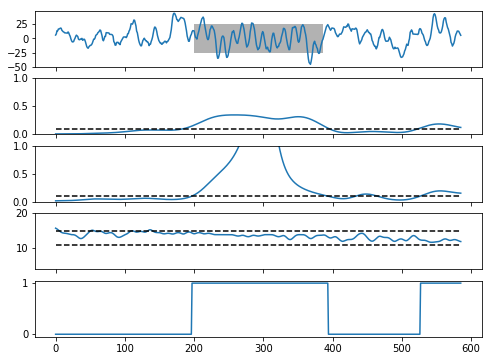

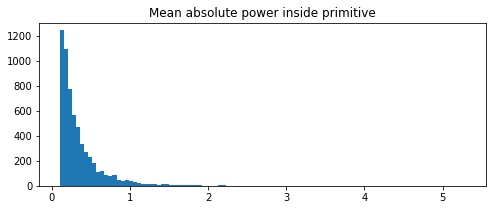

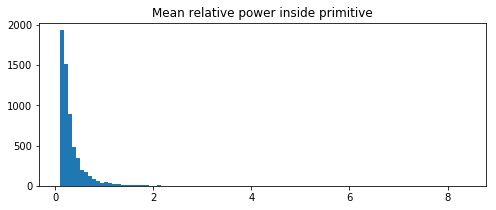

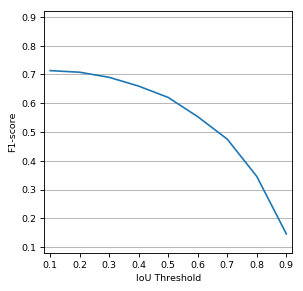

Overlapping groups for Valid 2 with size at least 5
Group size 5. Page idx: 203. Group: [21, 22, 23, 24, 25]
Group size 5. Page idx: 266. Group: [94, 95, 96, 97, 98]
Group size 5. Page idx: 428. Group: [346, 347, 348, 349, 350]
Group size 5. Page idx: 438. Group: [384, 385, 386, 387, 388]
Group size 5. Page idx: 589. Group: [467, 468, 469, 470, 471]
Group size 6. Page idx: 596. Group: [477, 478, 479, 480, 481, 482]
Group size 6. Page idx: 751. Group: [618, 619, 620, 621, 622, 623]
Group size 5. Page idx: 807. Group: [797, 798, 799, 800, 801]
Group size 5. Page idx: 807. Group: [802, 803, 804, 805, 806]
Group size 5. Page idx: 849. Group: [874, 875, 876, 877, 878]
Group size 5. Page idx: 1280. Group: [1005, 1006, 1007, 1008, 1009]
Group size 5. Page idx: 1295. Group: [1047, 1048, 1049, 1050, 1051]
Group size 5. Page idx: 1305. Group: [1087, 1088, 1089, 1090, 1091]
Group size 5. Page idx: 1313. Group: [1114, 1115, 1116, 1117, 1118]


In [137]:
this_pages = dataset.get_subject_pages(subject_id=subject_id) 
this_stamps = dataset.get_subject_stamps(subject_id=subject_id)

# Get power
signal_for_power = utils.broad_filter(original_signal, fs, lowcut=1, highcut=35) / dataset.global_std
band_power_sigma, sigma_signal = estimate_band_power(signal_for_power, fs, 13, 51)
band_power_near, near_signal = estimate_band_power(signal_for_power, fs, 6, 71)
relative_power_sigma = band_power_sigma / (band_power_near + 1e-3)

# Normalization (REMOVE THIS)
binary_sequence = utils.stamp2seq(this_stamps, 0, signal_for_power.size-1)
ss_abs_power = band_power_sigma[binary_sequence == 1]
ss_rel_power = relative_power_sigma[binary_sequence == 1]
max_abs_power = np.percentile(ss_abs_power, 90)
max_rel_power = np.percentile(ss_rel_power, 90) 
min_abs_power = band_power_sigma.min()
min_rel_power = relative_power_sigma.min()
band_power_sigma = (band_power_sigma-min_abs_power) / (max_abs_power-min_abs_power)
relative_power_sigma = (relative_power_sigma-min_rel_power) / (max_rel_power-min_rel_power)

# Get inst frequency from peak counting
signal_for_peaks = utils.broad_filter(original_signal, fs, lowcut=1, highcut=25) / dataset.global_std
inst_frequency = estimate_inst_frequency(signal_for_peaks)

# Find stamp candidates (primitives)
low_sigma_freq = 11
high_sigma_freq = 15
abs_tol = 0.1
rel_tol = 0.1
mean_power_abs_tol = 0.1
mean_power_rel_tol = 0.1
valid_abs = (band_power_sigma >= abs_tol).astype(np.int32)
valid_rel = (relative_power_sigma >= rel_tol).astype(np.int32)
valid_freq = (inst_frequency >= low_sigma_freq).astype(np.int32) * (inst_frequency <= high_sigma_freq).astype(np.int32)
valid_both = valid_abs * valid_rel * valid_freq
primitive_mark = utils.seq2stamp(valid_both)
primitive_mark = stamp_correction.combine_close_stamps(primitive_mark, fs, 0.1)
primitive_mark = stamp_correction.filter_duration_stamps(primitive_mark, fs, 0.1, 5)
primitive_mark = stamp_correction.combine_close_stamps(primitive_mark, fs, 0.3)

# Example
fig, ax = plt.subplots(5, 1, figsize=(8, 6), sharex=True)
single_stamp = this_stamps[200]
start_sample = single_stamp[0] - 200
end_sample = single_stamp[1] + 200
n_samples = end_sample - start_sample
ax[0].plot(original_signal[start_sample:end_sample])
ax[0].fill_between([200, 200+(single_stamp[1]-single_stamp[0])], 25, -25, alpha=0.3, facecolor='k')
ax[1].plot(band_power_sigma[start_sample:end_sample])
ax[1].plot([0, n_samples], [abs_tol, abs_tol], '--k')
ax[1].set_ylim([0, 1])
ax[2].plot(relative_power_sigma[start_sample:end_sample])
ax[2].plot([0, n_samples], [rel_tol, rel_tol], '--k')
ax[2].set_ylim([0, 1])
ax[3].plot(inst_frequency[start_sample:end_sample])
ax[3].plot([0, n_samples], [low_sigma_freq, low_sigma_freq], '--k')
ax[3].plot([0, n_samples], [high_sigma_freq, high_sigma_freq], '--k')
ax[3].set_ylim([4, 20])
ax[4].plot(valid_both[start_sample:end_sample])
plt.show()

# Now remove low power marks
improved_primitive_mark = []
abs_power_list = []
rel_power_list = []
for single_primitive in primitive_mark:
    stamp_abs_power = np.mean(band_power_sigma[single_primitive[0]:single_primitive[1]])
    stamp_rel_power = np.mean(relative_power_sigma[single_primitive[0]:single_primitive[1]])
    abs_power_list.append(stamp_abs_power)
    rel_power_list.append(stamp_rel_power)
    if (stamp_abs_power >= mean_power_abs_tol) and (stamp_rel_power >= mean_power_rel_tol):
        improved_primitive_mark.append(single_primitive)
primitive_mark = np.stack(improved_primitive_mark, axis=0)

primitive_mark = stamp_correction.combine_close_stamps(primitive_mark, fs, 0.8)
primitive_mark = stamp_correction.filter_duration_stamps(primitive_mark, fs, 0.3, 3)

plt.figure(figsize=(8, 3))
plt.title('Mean absolute power inside primitive')
plt.hist(abs_power_list, bins=100)
plt.show()

plt.figure(figsize=(8, 3))
plt.title('Mean relative power inside primitive')
plt.hist(rel_power_list, bins=100)
plt.show()
    
# Model predictions
model_stamps_list = []
iou_list = np.arange(1, 10) * 0.1
f1_vs_iou_list = []
this_seed = subject_seed_set_dict[subject_id][0]
set_name = subject_seed_set_dict[subject_id][1]
prediction_obj = predictions_dict[this_seed][set_name]
prediction_obj.set_probability_threshold(optimal_thr_list[this_seed])
this_detections = prediction_obj.get_subject_stamps(subject_id=subject_id)
f1_vs_iou = metrics.metric_vs_iou(
    this_stamps, this_detections, iou_list)
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=80)
ax.plot(iou_list, f1_vs_iou)
ax.set_xlim([0.1 - 0.02, 0.9 + 0.02])
ax.set_ylim([0.1 - 0.02, 0.9 + 0.02])
ax.set_yticks([0.1*i for i in range(1, 10)])
ax.set_xticks([0.1*i for i in range(1, 10)])
ax.tick_params(labelsize=8.5)
ax.set_xlabel('IoU Threshold', fontsize=8.5)
ax.set_ylabel('F1-score', fontsize=8.5)
ax.yaxis.grid()
plt.show()

thr_size = 5
print('Overlapping groups for Valid 2 with size at least %d' % thr_size)
to_print_list = [sub_group for sub_group in groups_overlap_2 if len(sub_group)>=thr_size]
for single_group in to_print_list:
    single_page = int(raw_stamps_2[single_group[0], :].mean() / dataset.page_size)
    print('Group size %d. Page idx: %d. Group: %s' % (len(single_group), this_pages.tolist().index(single_page), single_group))

In [138]:
model_stamps_color = CUSTOM_COLOR['blue']
expert_stamps_color = CUSTOM_COLOR['red']
primitive_stamps_color = CUSTOM_COLOR['green']
raw_stamps_color = '#B71C1C'
fontsize = 8

iou_range = [0, 1]
duration_range = [0, 5]
min_n_overlapping = 2


overlaps_with_1 = overlap_matrix(this_stamps, raw_stamps_1).sum(axis=1)
overlaps_with_2 = overlap_matrix(this_stamps, raw_stamps_2).sum(axis=1)
useful_n_overlaps = np.where( (overlaps_with_1 >=min_n_overlapping) |  (overlaps_with_2 >=min_n_overlapping))[0]


# Matching:
this_iou_array, this_idx_array = metrics.matching(this_stamps, this_detections)
this_expert_iou = this_iou_array
n_detections = this_detections.shape[0]
this_dectection_iou = np.zeros(n_detections)
for i in range(n_detections):
    if i in this_idx_array:
        matching_idx = np.where(this_idx_array == i)[0][0]
        this_dectection_iou[i] = this_iou_array[matching_idx]        

# filter
idx_useful_iou = np.where( (this_expert_iou >= iou_range[0]) & (this_expert_iou <= iou_range[1]) )[0]
duration_expert = (this_stamps[:, 1] - this_stamps[:, 0]) / fs
idx_useful_duration = np.where( (duration_expert >= duration_range[0]) & (duration_expert <= duration_range[1]) )[0]
idx_useful = [i for i in idx_useful_iou if i in idx_useful_duration and i in useful_n_overlaps]
filtered_expert = this_stamps[idx_useful]
filtered_detections = this_detections
this_expert_iou = this_expert_iou[idx_useful]


def plot_event(event_idx, show_model, show_expert, show_primitive, side_context=10):
    fig = plt.figure(figsize=(12, 10), dpi=DPI)
    gs = gridspec.GridSpec(8, 1, height_ratios=[1, 1, 1, 1, 1, 3, 2, 2])
    
    event_idx = event_idx - 1

    event_chosen = filtered_expert[event_idx, :]
    iou_chosen = this_expert_iou[event_idx]

    center_sample = int(np.mean(event_chosen))
    start_sample = int(center_sample - side_context * fs)
    end_sample = int(center_sample + side_context * fs)
    page_of_center = center_sample // dataset.page_size
    segment_signal = signal_for_power[start_sample:end_sample] * dataset.global_std
    if show_expert:
        segment_stamps = filter_stamps(this_stamps, start_sample, end_sample)
        segment_stamps_valid_1 = filter_stamps(raw_stamps_1, start_sample, end_sample)
        segment_stamps_valid_2 = filter_stamps(raw_stamps_2, start_sample, end_sample)
    else:
        segment_stamps = []
        segment_stamps_valid_1 = []
        segment_stamps_valid_2 = []
    if show_model:
        segment_model_stamps = filter_stamps(this_detections, start_sample, end_sample)
    else:
        segment_model_stamps = []
    if show_primitive:
        segment_primitive = filter_stamps(primitive_mark, start_sample, end_sample)
    else:
        segment_primitive = []
    
    time_axis = np.arange(start_sample, end_sample) / fs
    x_ticks = np.arange(time_axis[0], time_axis[-1], 2)
    x_ticks_minor = np.arange(time_axis[0], time_axis[-1], 0.5)
    
    
    # Show absolute power
    gs_idx = 0
    ax = fig.add_subplot(gs[gs_idx])
    
    ax.plot(time_axis, band_power_sigma[start_sample:end_sample], linewidth=1, color=CUSTOM_COLOR['grey'])
    ax.plot([time_axis[0], time_axis[-1]], [abs_tol, abs_tol], 'k--', linewidth=1)
    ax.set_xticks(x_ticks_minor, minor=True)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([time_axis[0], time_axis[-1]])
    ax.set_ylabel('AbsP', fontsize=fontsize)   
    ax.set_ylim([0, 1])
    ax.tick_params(labelsize=fontsize)
    ax.grid(b=True, axis='x', which='minor')
    
    # Show relative power
    gs_idx = gs_idx + 1
    ax = fig.add_subplot(gs[gs_idx])
    
    ax.plot(time_axis, relative_power_sigma[start_sample:end_sample], linewidth=1, color=CUSTOM_COLOR['grey'])
    ax.plot([time_axis[0], time_axis[-1]], [abs_tol, abs_tol], 'k--', linewidth=1)
    ax.set_xticks(x_ticks_minor, minor=True)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([time_axis[0], time_axis[-1]])
    ax.set_ylabel('RelP', fontsize=fontsize)   
    ax.set_ylim([0, 1])
    ax.tick_params(labelsize=fontsize)
    ax.grid(b=True, axis='x', which='minor')
    
    # Show inst frequency
    gs_idx = gs_idx + 1
    ax = fig.add_subplot(gs[gs_idx])
    
    ax.plot(time_axis, inst_frequency[start_sample:end_sample], linewidth=1, color=CUSTOM_COLOR['grey'])
    ax.plot([time_axis[0], time_axis[-1]], [low_sigma_freq, low_sigma_freq], 'k--', linewidth=1)
    ax.plot([time_axis[0], time_axis[-1]], [high_sigma_freq, high_sigma_freq], 'k--', linewidth=1)
    ax.set_xticks(x_ticks_minor, minor=True)
    ax.set_xticks([])
    ax.set_yticks([low_sigma_freq, high_sigma_freq])
    ax.set_xlim([time_axis[0], time_axis[-1]])
    ax.set_ylabel('f [Hz]', fontsize=fontsize)   
    ax.set_ylim([4, 20])
    ax.tick_params(labelsize=fontsize)
    ax.grid(b=True, axis='x', which='minor')

    # Show valid 1
    gs_idx = gs_idx + 1
    ax = fig.add_subplot(gs[gs_idx])
    
    delta_y = 0.1
    for j, single_stamp in enumerate(segment_stamps_valid_1):
        n_stamps = len(segment_stamps_valid_1)
        dy_for_stamp = 1 / n_stamps
        ax.plot(single_stamp/fs, [j*dy_for_stamp, j*dy_for_stamp], color=raw_stamps_color, linewidth=1.5)
    ax.set_xticks([])
    ax.set_xticks(x_ticks_minor, minor=True)
    ax.set_yticks([])
    ax.set_ylim([-delta_y, 1+delta_y])
    ax.set_xlim([time_axis[0], time_axis[-1]])
    ax.set_ylabel('V1', fontsize=fontsize)
    ax.grid(b=True, axis='x', which='minor')
    
    # Show valid 2
    gs_idx = gs_idx + 1
    ax = fig.add_subplot(gs[gs_idx])
    
    delta_y = 0.1
    for j, single_stamp in enumerate(segment_stamps_valid_2):
        n_stamps = len(segment_stamps_valid_2)
        dy_for_stamp = 1/n_stamps
        ax.plot(single_stamp/fs, [j*dy_for_stamp, j*dy_for_stamp], color=raw_stamps_color, linewidth=1.5)
    ax.set_xticks(x_ticks_minor, minor=True)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylim([-delta_y, 1+delta_y])
    ax.set_xlim([time_axis[0], time_axis[-1]])
    ax.set_ylabel('V2', fontsize=fontsize) 
    ax.tick_params(labelsize=fontsize)
    ax.grid(b=True, axis='x', which='minor')
    
    # Show signal
    gs_idx = gs_idx + 1
    ax = fig.add_subplot(gs[gs_idx])
    y_max = 200
    ax.plot(time_axis, segment_signal, linewidth=1, color=CUSTOM_COLOR['grey'])
    
    # Expert
    expert_center = -50
    stamp_label_used = False
    for single_stamp in segment_stamps:
        if stamp_label_used:
            label = None
        else:
            label = 'Expert'
            stamp_label_used = True
        ax.plot(
            single_stamp / fs, [expert_center, expert_center], 
            color=expert_stamps_color, linewidth=2, label=label)
    
    # Primitive
    primitive_center = -40
    stamp_label_used = False
    for single_stamp in segment_primitive:
        if stamp_label_used:
            label = None
        else:
            label = 'Primitive'
            stamp_label_used = True
        ax.plot(
            single_stamp / fs, [primitive_center, primitive_center], 
            color=primitive_stamps_color, linewidth=2, label=label)
    
    # Model
    stamp_label_used = False
    for single_stamp in segment_model_stamps:
        if stamp_label_used:
            label = None
        else:
            label = 'Model'
            stamp_label_used = True
        ax.fill_between(
            single_stamp / fs, y_max, -y_max, 
            facecolor=model_stamps_color, alpha=0.3, label=label,
            edgecolor='k', linewidth=1.5)
    
    if len(segment_stamps)>0 or len(segment_primitive)>0 or len(segment_model_stamps)>0:
        ax.legend(loc='upper right', fontsize=fontsize)
    ax.set_xticks(x_ticks_minor, minor=True)
    ax.set_xticks(x_ticks)
    ax.set_yticks([-y_max, 0, y_max])
    ax.set_xlim([time_axis[0], time_axis[-1]])
    ax.set_ylabel('uV', fontsize=fontsize)   
    ax.set_ylim([-y_max, y_max])
    ax.tick_params(labelsize=fontsize)
    ax.grid(b=True, axis='x', which='minor')
    ax.set_xlabel('Time [s]', fontsize=fontsize)
    
    # Show signal sigma
    gs_idx = gs_idx + 1
    ax = fig.add_subplot(gs[gs_idx])
    ax.plot(time_axis, sigma_signal[start_sample:end_sample], linewidth=1, color=CUSTOM_COLOR['grey'])
    ax.set_xticks(x_ticks_minor, minor=True)
    ax.set_xticks(x_ticks)
    ax.set_yticks([])
    ax.set_xlim([time_axis[0], time_axis[-1]])
    ax.tick_params(labelsize=fontsize)
    ax.grid(b=True, axis='x', which='minor')
    ax.set_ylim([-4, 4])
    
    # Show signal for nearby band
    gs_idx = gs_idx + 1
    ax = fig.add_subplot(gs[gs_idx])
    ax.plot(time_axis, near_signal[start_sample:end_sample], linewidth=1, color=CUSTOM_COLOR['grey'])
    ax.set_xticks(x_ticks_minor, minor=True)
    ax.set_xticks(x_ticks)
    ax.set_yticks([])
    ax.set_xlim([time_axis[0], time_axis[-1]])
    ax.tick_params(labelsize=fontsize)
    ax.grid(b=True, axis='x', which='minor')
    ax.set_ylim([-4, 4])
    
    plt.tight_layout()
    plt.show()

In [139]:
show_model = True
show_expert = True
show_primitive = True

print('Showing events with IoU in range %s' % iou_range)
print('Showing events with duration in range %s [s]' % duration_range)
print('Showing events with %d overlaps' % min_n_overlapping)
max_value = filtered_expert.shape[0]
print('Number of real events selected %d' % max_value)

style = {'description_width': 'initial'}
layout= widgets.Layout(width='1000px')
widgets.interact(
    lambda event_idx: plot_event(event_idx, show_model, show_expert, show_primitive),
    event_idx=widgets.IntSlider(
        min=1,max=max_value,step=1,value=115, continuous_update=False, 
        style=style,
        layout=layout));

# s11, event 188, muy rapido, event 263, (2 overlaps->115)

Showing events with IoU in range [0, 1]
Showing events with duration in range [0, 5] [s]
Showing events with 2 overlaps
Number of real events selected 392


interactive(children=(IntSlider(value=115, continuous_update=False, description='event_idx', layout=Layout(wid…